In [2]:
!pip install opencv-python numpy kagglehub matplotlib

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#funkcja do wyświetlania obrazów w notebook'ach
def pokaz_obraz(img, tytul="Obraz"):
    plt.figure(figsize=(8, 8))
#konwercja formatu openCV na RGB
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.title(tytul)
    plt.axis('off')
    plt.show()

Definiujemy strukturę bazy wzorców oraz funkcję, która przypisuje obrazy do kategorii - trójkąt, okrąg na podstawie nazw plików

In [4]:
#wzorce
BAZA_WZORCOW = {
    'TROJKAT': {},
    'KOLO': {},
    'STOP (Oktagon)': {},
    'KWADRAT': {}
}

def wczytaj_baze_wzorcow(sciezka_folderu):
    if not os.path.exists(sciezka_folderu):
        print(f"Błąd: Folder {sciezka_folderu} nie istnieje.")
        return


    for plik in os.listdir(sciezka_folderu):
        sciezka_pliku = os.path.join(sciezka_folderu, plik)
        img = cv2.imread(sciezka_pliku)
        if img is None: continue
        
        nazwa = os.path.splitext(plik)[0] #np: A7
        
#kategoryzacja po nazwie
        if nazwa.startswith('A'): 
            BAZA_WZORCOW['TROJKAT'][nazwa] = img
        elif 'STOP' in nazwa or 'B20' in nazwa:
            BAZA_WZORCOW['STOP (Oktagon)'][nazwa] = img
        elif nazwa.startswith('B') or nazwa.startswith('C') or nazwa.startswith('D'):
            BAZA_WZORCOW['KOLO'][nazwa] = img
        elif nazwa.startswith('D1') or 'KW' in nazwa:
            BAZA_WZORCOW['KWADRAT'][nazwa] = img
            
        print(f"załadowano {nazwa}")


Funkcje do wyodrębnienia piktogramu ze znaku, który zostaje zamieniony na formę czerni i bieli.
Algorytm dopasowuje czarno biały obraz do wzorców i wybiera znak z największym prawdopodobieństwem 

In [5]:
def wyodrebnij_tresc(obraz_bgr, kolor, ksztalt):
    img_resized = cv2.resize(obraz_bgr, (64, 64))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    #LOGIKA KOLORÓW
    if kolor == "Niebieski" or "STOP" in ksztalt:
        #szukamy białego na ciemnym tle
        img_eq = cv2.equalizeHist(gray)
        _, binary = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return binary
    else:
        #szukamy czarnego na jasnym tle
        binary = cv2.adaptiveThreshold(img_blurred, 255, 
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, 11, 2)
        return binary

def zidentyfikuj_znak_smart(wycinek, ksztalt, kolor_wykryty):
    #przerabiamy wycinek z ulicy na wersję czarno-białą
    img_ready = wyodrebnij_tresc(wycinek, kolor_wykryty, ksztalt)

    najlepszy_match = "Nieznany"
    najwyzszy_wynik = -1.0
    
    #lista kategorii do sprawdzenia
    kategorie = [ksztalt]
    if ksztalt == "STOP (Oktagon)": kategorie.append("KOLO")
    if ksztalt == "KOLO": kategorie.append("STOP (Oktagon)")

    for kat in kategorie:
        dostepne_wzorce = BAZA_WZORCOW.get(kat, {})
        
        for nazwa, wzorzec_bgr in dostepne_wzorce.items():
            
            #przerabiamy wzorzec zakładając że w bazie jest w szarości
            if len(wzorzec_bgr.shape) == 2: #jeśli gjest szary zrób BGR
                wzorzec_bgr = cv2.cvtColor(wzorzec_bgr, cv2.COLOR_GRAY2BGR)

            wzorzec_bin = wyodrebnij_tresc(wzorzec_bgr, kolor_wykryty, ksztalt)
            
            #porównanie
            res = cv2.matchTemplate(img_ready, wzorzec_bin, cv2.TM_CCOEFF_NORMED)
            wynik = res[0][0]
            
            if wynik > najwyzszy_wynik:
                najwyzszy_wynik = wynik
                najlepszy_match = nazwa
                
    return najlepszy_match, najwyzszy_wynik

ORB - Funkcja szuka punktów charakterystycznych na wyciętym fragmencie obrazu i porównuje je z bazą danych. Jeśli liczba dopasowanych punktów przekroczy określony próg, program zidyntyfikuje konkretny typ znaku. 

In [6]:
def zidentyfikuj_znak_orb(wycinek, ksztalt):
    
    
    #inicjalizacja ORB
    orb = cv2.ORB_create(nfeatures=1000)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    #konwersja wycinka na szarość
    if wycinek is None or wycinek.size == 0: return "Błąd", 0
    gray_scene = cv2.cvtColor(wycinek, cv2.COLOR_BGR2GRAY)
    
    #znajdź punkty na wycinku
    kp_scene, des_scene = orb.detectAndCompute(gray_scene, None)
    if des_scene is None: return "Zbyt rozmyty", 0

    najlepsza_nazwa = "Nieznany"
    max_trafien = 0
    
    #wybór odpowiedniej kategorii wzorców
    kategorie = [ksztalt]
    #sprawdź też inne kategorie jeśli kształt jest niepewny
    if ksztalt == "STOP (Oktagon)": kategorie.append("KOLO") 

    for kat in kategorie:
        wzorce = BAZA_WZORCOW.get(kat, {})
        
        for nazwa, img_wzor in wzorce.items():
            #sprawdzenie skali szarości
            if len(img_wzor.shape) == 3:
                gray_wzor = cv2.cvtColor(img_wzor, cv2.COLOR_BGR2GRAY)
            else:
                gray_wzor = img_wzor
            
            #oblicz punkty dla wzorca
            kp_wzor, des_wzor = orb.detectAndCompute(gray_wzor, None)
            if des_wzor is None: continue
            
            #porównaj punkty
            try:
                matches = bf.knnMatch(des_wzor, des_scene, k=2)
                # Filtrowanie dobrych punktów (Lowe's ratio test)
                dobre = [m for m, n in matches if m.distance < 0.75 * n.distance]
                
                if len(dobre) > max_trafien:
                    max_trafien = len(dobre)
                    najlepsza_nazwa = nazwa
            except:
                continue

    #próg minimalny 
    if max_trafien > 4:
        return najlepsza_nazwa, max_trafien
    else:
        return "Nieznany", max_trafien

Znajdujemy znaki po kolorach i kształcie, dopasowujemy wycięte symbole do wzorców z folderu. Podaje rozpoznane znaki z % pewności

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

FOLDER_KLASYFIKACJI = r"C:\Users\pgesk\Desktop\studia\znaki_drogowe\classification"

def przygotuj_maske_symbolu(wycinek, kolor_tla):
    
    #Decyduje czy szukamy czarnego czy białego symbolu w zależności od tła.
    
    gray = cv2.cvtColor(wycinek, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    if kolor_tla == "Niebieski":
        # białe symbole na czarnym tle - binaryzacja normalna
        _, maska = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        # czarny symbol na jasnym tle - binaryzacja odwrotna
        _, maska = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
    maska = cv2.morphologyEx(maska, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    return maska

def klasyfikuj_symbol(maska_symbolu, sciezka_bazy):
    if not os.path.exists(sciezka_bazy): return "Brak bazy", 0.0
    
    std_size = (64, 64)
    maska_resized = cv2.resize(maska_symbolu, std_size)
    pliki = [f for f in os.listdir(sciezka_bazy) if f.lower().endswith(('.png', '.jpg'))]
    
    najlepsza = "Nieznany"
    max_score = 0.0
    
    for plik in pliki:
        wzor = cv2.imread(os.path.join(sciezka_bazy, plik), cv2.IMREAD_GRAYSCALE)
        if wzor is None: continue
        
        #wzorce zazwyczaj są czarne na białym, więc odwracamy je do porównania z maską
        _, wzor_bin = cv2.threshold(wzor, 127, 255, cv2.THRESH_BINARY_INV)
        wzor_resized = cv2.resize(wzor_bin, std_size)
        
        res = cv2.matchTemplate(maska_resized, wzor_resized, cv2.TM_CCORR_NORMED)
        if res[0][0] > max_score:
            max_score = res[0][0]
            najlepsza = os.path.splitext(plik)[0]
            
    return najlepsza, round(max_score * 100, 1)

def analizuj_obraz_final(sciezka_obrazu):
    img = cv2.imread(sciezka_obrazu)
    if img is None: 
        print("błąd wczytania pliku")
        return [] # Zwracamy pustą listę w razie błędu

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_vis = img.copy()
    
    #lista do wyników
    ZNALEZIONE_ZNAKI = [] 

    zakresy = {
        "Zolty": [(np.array([15, 70, 70]), np.array([35, 255, 255]))],
        "Czerwony": [(np.array([0, 70, 50]), np.array([10, 255, 255])),
                     (np.array([170, 70, 50]), np.array([180, 255, 255]))],
        "Niebieski": [(np.array([100, 150, 0]), np.array([140, 255, 255]))]
    }

    print(f"--- START ANALIZY: {os.path.basename(sciezka_obrazu)} ---")

    for kolor_nazwa, zakresy_hsv in zakresy.items():
        maska_koloru = np.zeros(hsv.shape[:2], dtype="uint8")
        for (d, g) in zakresy_hsv:
            maska_koloru = cv2.bitwise_or(maska_koloru, cv2.inRange(hsv, d, g))
        
        maska_koloru = cv2.morphologyEx(maska_koloru, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
        kontury, _ = cv2.findContours(maska_koloru, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in kontury:
            if cv2.contourArea(cnt) > 1000:
                #rozpoznawanie geometrii
                obwod = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.03 * obwod, True)
                wierzcholki = len(approx)
                
                ksztalt = "Nieznany"
                if wierzcholki == 3: ksztalt = "TROJKAT"
                elif wierzcholki == 4:
                    x, y, w, h = cv2.boundingRect(approx)
                    ksztalt = "KWADRAT" if 0.9 <= w/h <= 1.1 else "PROSTOKAT"
                elif wierzcholki == 8: ksztalt = "STOP"
                elif wierzcholki > 8: ksztalt = "KOLO"
                
                #jeżeśli kształt jest sensowny dla znaku
                if ksztalt in ["TROJKAT", "KWADRAT", "KOLO", "STOP"]:
                    
                    x, y, w, h = cv2.boundingRect(cnt)
                    wycinek = img[y:y+h, x:x+w]
                    
                    #wyciągamy symbol (zależnie od koloru tła!)
                    maska_symbolu = przygotuj_maske_symbolu(wycinek, kolor_nazwa)
                    
                    #klasyfikujemy
                    nazwa_znaku, pewnosc = klasyfikuj_symbol(maska_symbolu, FOLDER_KLASYFIKACJI)
                    
                    #zapisujemy wynik do słownika
                    wynik = {
                        "nazwa": nazwa_znaku,
                        "ksztalt": ksztalt,
                        "kolor": kolor_nazwa,
                        "pewnosc": pewnosc,
                        "pozycja": (x, y, w, h)
                    }
                    ZNALEZIONE_ZNAKI.append(wynik)

                    # Rysujemy na obrazku podglądowym
                    cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    cv2.putText(img_vis, f"{nazwa_znaku}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                    print(f"-> Znaleziono: {ksztalt}/{kolor_nazwa} -> {nazwa_znaku} ({pewnosc}%)")

    #wyświetl obraz z wynikami
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Znaleziono {len(ZNALEZIONE_ZNAKI)} znaków")
    plt.show()

    #ZWRACAMY DANE
    return ZNALEZIONE_ZNAKI

IoU - dokładnie porównuje piktogramy oraz tworzy kolorowe zestawienie nakładania się obrazów. Ukazuje na wykresach jak dobrze pasuje on do wzorca z bazy

### Metoda IoU (Intersection over Union)

Oblicza stosunek części wspólnej dwóch masek binarnych do sumy ich całkowitej powierzchni.
|
* **Piksele zielone**: piksele idealnie dopasowane
* **Piksele czerwone**: szum
* **Piksele niebieskie**: elementy które nie zostały wyodrębnione ze zdjęcia

Analiza: 1.jpg
-> STOP: B20 (0.88)


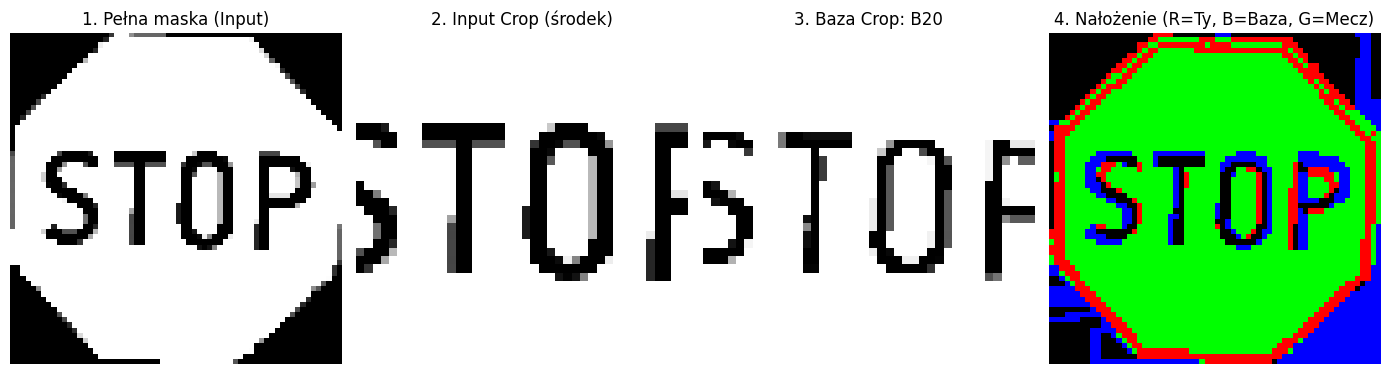

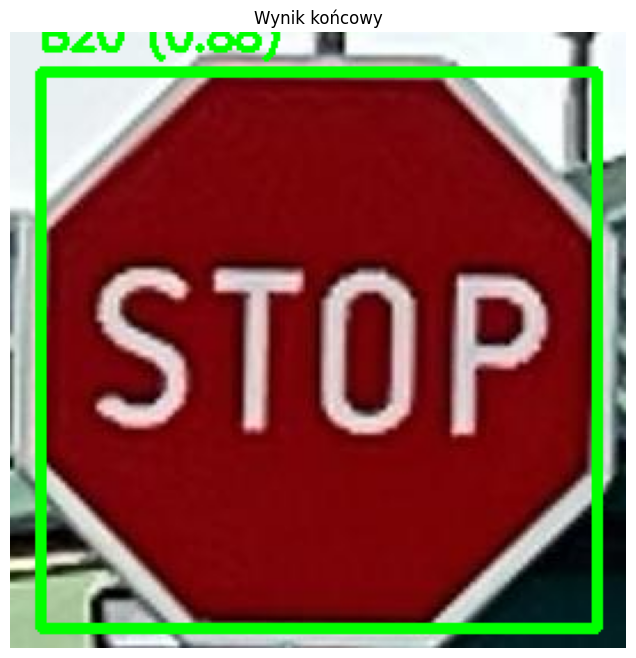

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

FOLDER_KLASYFIKACJI = r"C:\Users\pgesk\Desktop\studia\znaki_drogowe\classification"

#funkcja do wizualizacji RGB
def stworz_wizualizacje_nalozenia(img_input, img_base):
    """
    Tworzy obraz RGB pokazujący różnice między dwoma maskami binarnymi.
    Input (img_input) i Baza (img_base) muszą mieć ten sam rozmiar (np. 64x64).
    """
    #sprawdzenie binarności obrazów
    _, bin_input = cv2.threshold(img_input, 127, 255, cv2.THRESH_BINARY)
    _, bin_base = cv2.threshold(img_base, 127, 255, cv2.THRESH_BINARY)

    h, w = bin_input.shape[:2]
    #tworzenie pustego obrazu
    overlap_img = np.zeros((h, w, 3), dtype=np.uint8)

    # 1.zielony dla czesci wspolnych
    match = cv2.bitwise_and(bin_input, bin_base)
    overlap_img[match == 255] = [0, 255, 0] # G

    # 2.czerwony - szum
    input_only = cv2.bitwise_and(bin_input, cv2.bitwise_not(bin_base))
    overlap_img[input_only == 255] = [255, 0, 0] # R

    # 3.niebieski - brakujące elementy
    base_only = cv2.bitwise_and(bin_base, cv2.bitwise_not(bin_input))
    overlap_img[base_only == 255] = [0, 0, 255] # B

    return overlap_img

def przygotuj_obraz_do_porownania(wycinek, maska_ksztaltu, kolor_tla):
    
    if len(wycinek.shape) == 3:
        gray = cv2.cvtColor(wycinek, cv2.COLOR_BGR2GRAY)
    else:
        gray = wycinek

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    if kolor_tla == "Niebieski":
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        #odwracamy, żeby symbol był biały
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    if maska_ksztaltu is not None and maska_ksztaltu.shape[:2] == binary.shape[:2]:
        binary_masked = cv2.bitwise_and(binary, binary, mask=maska_ksztaltu)
    else:
        binary_masked = binary
        
    final_img = cv2.resize(binary_masked, (64, 64))
    return final_img

def klasyfikuj_z_folderami(maska_wejsciowa, sciezka_glowna, wykryty_ksztalt):
    """
    porównanie metodą IoU
    sprawdzamy gęstość pixeli zielonych w %
    """
    najlepsza_klasa = "Nieznany"
    najlepszy_wynik = 0.0  # Startujemy od 0 (0%)
    
    #WYBÓR PROGU AKCEPTACJI
    PROG_AKCEPTACJI = 0.30
    
    MARGINES = 12 
    h, w = maska_wejsciowa.shape
    
    #wycinamy środek z maski
    maska_center = maska_wejsciowa[MARGINES:h-MARGINES, MARGINES:w-MARGINES]
    
    #binaryzacja
    _, maska_center = cv2.threshold(maska_center, 127, 255, cv2.THRESH_BINARY)
    
    if not os.path.exists(sciezka_glowna): return "Błąd ścieżki", 0.0

    wszystkie_foldery = [f for f in os.listdir(sciezka_glowna) if os.path.isdir(os.path.join(sciezka_glowna, f))]
    
    #filtrowanie folderów po kształcie
    foldery_do_przesukania = []
    for folder in wszystkie_foldery:
        litera = folder[0].upper()
        match wykryty_ksztalt:
            case "TROJKAT":
                if litera == 'A': foldery_do_przesukania.append(folder)
            case "KOLO":
                if litera in ['B', 'C']: foldery_do_przesukania.append(folder)
            case "KWADRAT":
                if litera in ['D', 'E']: foldery_do_przesukania.append(folder)
            case "STOP":
                if folder.upper().startswith('B-20'): foldery_do_przesukania.append(folder)
            case _:
                foldery_do_przesukania.append(folder)     
    if not foldery_do_przesukania: foldery_do_przesukania = wszystkie_foldery

    #główna pętla porównawcza
    for nazwa_folderu in foldery_do_przesukania:
        sciezka_do_klasy = os.path.join(sciezka_glowna, nazwa_folderu)
        pliki_wzorcow = [f for f in os.listdir(sciezka_do_klasy) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for plik in pliki_wzorcow:
            sciezka_pliku = os.path.join(sciezka_do_klasy, plik)
            
            wzorzec = cv2.imread(sciezka_pliku, cv2.IMREAD_GRAYSCALE)
            if wzorzec is None: continue
            
            #binaryzacja wzorca 
            _, wzorzec_bin = cv2.threshold(wzorzec, 127, 255, cv2.THRESH_BINARY_INV)
            wzorzec_resized = cv2.resize(wzorzec_bin, (64, 64))
            
            #wycinamy środek wzorca
            wzorzec_center = wzorzec_resized[MARGINES:h-MARGINES, MARGINES:w-MARGINES]

        
            #obliczanie IoU
            intersection = cv2.bitwise_and(maska_center, wzorzec_center)
            
            union = cv2.bitwise_or(maska_center, wzorzec_center)
            
            count_inter = np.count_nonzero(intersection)
            count_union = np.count_nonzero(union)
            
            if count_union == 0:
                score = 0
            else:
                score = count_inter / count_union 
            
            #jeśli wynik > od wyniku dotychczasowego zapamiętujemy
            if score > najlepszy_wynik:
                najlepszy_wynik = score
                najlepsza_klasa = nazwa_folderu 

    # porównanie z progiem akceptacji
    if najlepszy_wynik < PROG_AKCEPTACJI:
        return "Nieznany", najlepszy_wynik
    
    return najlepsza_klasa, najlepszy_wynik
def analizuj_obraz_final(sciezka_obrazu):
    img = cv2.imread(sciezka_obrazu)
    if img is None: 
        print(f"Nie znaleziono pliku: {sciezka_obrazu}")
        return

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_vis = img.copy()

    zakresy = {
        "Zolty": [(np.array([15, 70, 70]), np.array([35, 255, 255]))],
        "Czerwony": [(np.array([0, 70, 50]), np.array([10, 255, 255])),
                     (np.array([170, 70, 50]), np.array([180, 255, 255]))],
        "Niebieski": [(np.array([100, 150, 0]), np.array([140, 255, 255]))]
    }

    print(f"Analiza: {os.path.basename(sciezka_obrazu)}")

    for kolor_nazwa, zakresy_hsv in zakresy.items():
        maska_koloru = np.zeros(hsv.shape[:2], dtype="uint8")
        for (d, g) in zakresy_hsv:
            maska_koloru = cv2.bitwise_or(maska_koloru, cv2.inRange(hsv, d, g))
        
        maska_koloru = cv2.morphologyEx(maska_koloru, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
        kontury, _ = cv2.findContours(maska_koloru, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in kontury:
            if cv2.contourArea(cnt) > 1000:
                obwod = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.03 * obwod, True)
                wierzcholki = len(approx)
                
                ksztalt = "Nieznany"
                if wierzcholki == 3: ksztalt = "TROJKAT"
                elif wierzcholki == 4: ksztalt = "KWADRAT" 
                elif wierzcholki == 8: ksztalt = "STOP"
                elif wierzcholki > 8: ksztalt = "KOLO"
                
                if ksztalt in ["TROJKAT", "KWADRAT", "KOLO", "STOP"]:
                    x, y, w, h_rect = cv2.boundingRect(cnt)
                    
                    maska_ksztaltu_full = np.zeros(img.shape[:2], dtype="uint8")
                    cv2.drawContours(maska_ksztaltu_full, [cnt], -1, 255, thickness=cv2.FILLED)
                    
                    wycinek_img = img[y:y+h_rect, x:x+w]
                    wycinek_maski = maska_ksztaltu_full[y:y+h_rect, x:x+w]
                    
                    # 1.tworzenie maski 64x64
                    maska_wejsciowa = przygotuj_obraz_do_porownania(wycinek_img, wycinek_maski, kolor_nazwa)
                    
                    # 2.klasyfikacja
                    nazwa_znaku, pewnosc = klasyfikuj_z_folderami(maska_wejsciowa, FOLDER_KLASYFIKACJI, ksztalt)
                    
                    #wizualizacja na zdjęciu głównym
                    kolor_box = (0, 255, 0) if pewnosc > 0.5 else (0, 0, 255)
                    cv2.rectangle(img_vis, (x, y), (x+w, y+h_rect), kolor_box, 3)
                    cv2.putText(img_vis, f"{nazwa_znaku} ({pewnosc:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, kolor_box, 2)
                    
                    print(f"-> {ksztalt}: {nazwa_znaku} ({pewnosc:.2f})")

                    #w matplotlib zmieniamy rozmiar figury na szerszą, bo będą 4 wykresy
                    plt.figure(figsize=(14, 4))
                    
                    M = 12 #margines używany do cropa
                    
                    # Obraz 1 pełna maska
                    plt.subplot(1, 4, 1)
                    plt.imshow(maska_wejsciowa, cmap='gray')
                    plt.title("1. Pełna maska (Input)")
                    plt.axis('off')

                    # Obraz 2, co widzi algorytm?
                    plt.subplot(1, 4, 2)
                    plt.imshow(maska_wejsciowa[M:-M, M:-M], cmap='gray')
                    plt.title(f"2. Input Crop (środek)")
                    plt.axis('off')

                    #przygotowanie obrazu bazowego do wyświetlenia
                    baza_full_64x64 = None 
                    
                    plt.subplot(1, 4, 3)
                    if nazwa_znaku != "Nieznany":
                        path = os.path.join(FOLDER_KLASYFIKACJI, nazwa_znaku)
                        if os.path.exists(path) and os.listdir(path):
                            f_path = os.path.join(path, os.listdir(path)[0])
                            raw = cv2.imread(f_path, cv2.IMREAD_GRAYSCALE)
                            _, raw_bin = cv2.threshold(raw, 127, 255, cv2.THRESH_BINARY_INV)
                            baza_full_64x64 = cv2.resize(raw_bin, (64, 64))
                            
                            #crop bazy
                            plt.imshow(baza_full_64x64[M:-M, M:-M], cmap='gray')
                            plt.title(f"3. Baza Crop: {nazwa_znaku}")
                        else:
                             plt.title("Baza: Brak pliku")
                    else:
                        plt.title("Baza: Nieznany")
                    plt.axis('off')

                    #obraz 4 kolorowe nałożenie
                    plt.subplot(1, 4, 4)
                    if baza_full_64x64 is not None:
                        #porównanie pełnych obrazów 64x64p
                        overlap_rgb = stworz_wizualizacje_nalozenia(maska_wejsciowa, baza_full_64x64)
                        plt.imshow(overlap_rgb)
                        plt.title("4. Nałożenie (R=Ty, B=Baza, G=Mecz)")
                    else:
                        plt.title("Brak bazy do nałożenia")
                    plt.axis('off')
                    
                    plt.tight_layout()
                    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title("Wynik końcowy")
    plt.axis('off')
    plt.show()


SCIEZKA_ZDJECIA = r"C:\Users\pgesk\Desktop\studia\znaki_drogowe\classification\B20\1.jpg"
analizuj_obraz_final(SCIEZKA_ZDJECIA)

Skrypt integrujący wszystkie etapy: segmentację kolorów i kształtów, IoU. Generowanie raportu

Analiza pliku: 30.jpg


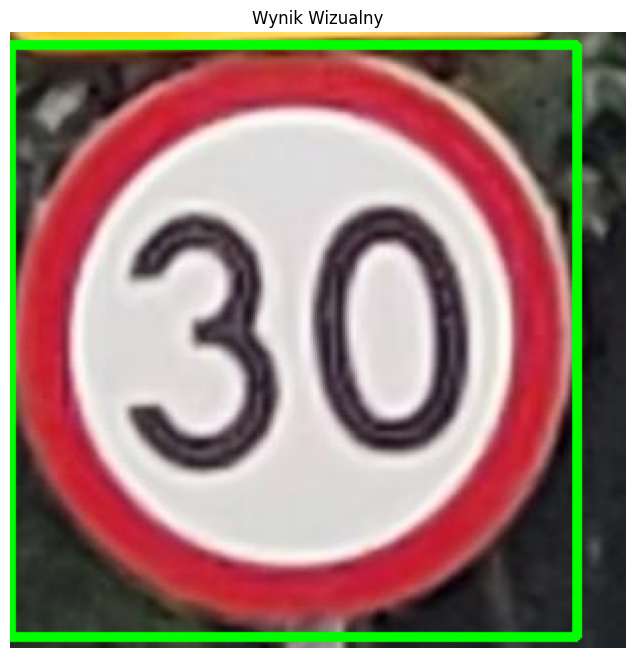


📢 PODSUMOWANIE DETEKCJI
✅ WYKRYTO ZNAK: B33 (79%)
   -> Interpretacja: Patrz folder B33



In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

FOLDER_KLASYFIKACJI = r"C:\Users\pgesk\Desktop\studia\znaki_drogowe\classification"

def stworz_wizualizacje_nalozenia(img_input, img_base):
    _, bin_input = cv2.threshold(img_input, 127, 255, cv2.THRESH_BINARY)
    _, bin_base = cv2.threshold(img_base, 127, 255, cv2.THRESH_BINARY)
    h, w = bin_input.shape[:2]
    overlap_img = np.zeros((h, w, 3), dtype=np.uint8)
    
    # Zielony (Wspólne)
    match = cv2.bitwise_and(bin_input, bin_base)
    overlap_img[match == 255] = [0, 255, 0]
    # Czerwony (Nadmiar Input)
    input_only = cv2.bitwise_and(bin_input, cv2.bitwise_not(bin_base))
    overlap_img[input_only == 255] = [255, 0, 0]
    # Niebieski (Brak w Input)
    base_only = cv2.bitwise_and(bin_base, cv2.bitwise_not(bin_input))
    overlap_img[base_only == 255] = [0, 0, 255]
    return overlap_img

def przygotuj_obraz_do_porownania(wycinek, maska_ksztaltu, kolor_tla):
    if len(wycinek.shape) == 3: gray = cv2.cvtColor(wycinek, cv2.COLOR_BGR2GRAY)
    else: gray = wycinek
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    if kolor_tla == "Niebieski": _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else: _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if maska_ksztaltu is not None and maska_ksztaltu.shape[:2] == binary.shape[:2]:
        binary_masked = cv2.bitwise_and(binary, binary, mask=maska_ksztaltu)
    else: binary_masked = binary
    return cv2.resize(binary_masked, (64, 64))

def klasyfikuj_z_folderami(maska_wejsciowa, sciezka_glowna, wykryty_ksztalt):
    najlepsza_klasa = "Nieznany"
    najlepszy_wynik = 0.0
    
    PROG_AKCEPTACJI = 0.45
    
    MARGINES = 12 
    h, w = maska_wejsciowa.shape
    maska_center = maska_wejsciowa[MARGINES:h-MARGINES, MARGINES:w-MARGINES]
    _, maska_center = cv2.threshold(maska_center, 127, 255, cv2.THRESH_BINARY)
    
    if not os.path.exists(sciezka_glowna): return "Błąd ścieżki", 0.0
    wszystkie_foldery = [f for f in os.listdir(sciezka_glowna) if os.path.isdir(os.path.join(sciezka_glowna, f))]
    
    foldery_do_przesukania = []
    for folder in wszystkie_foldery:
        litera = folder[0].upper()
        match wykryty_ksztalt:
            case "TROJKAT":
                if litera == 'A': foldery_do_przesukania.append(folder)
            case "KOLO":
                if litera in ['B', 'C']: foldery_do_przesukania.append(folder)
            case "KWADRAT":
                if litera in ['D', 'E']: foldery_do_przesukania.append(folder)
            case "STOP":
                if folder.upper().startswith('B-20'): foldery_do_przesukania.append(folder)
            case _: foldery_do_przesukania.append(folder)
    if not foldery_do_przesukania: foldery_do_przesukania = wszystkie_foldery

    for nazwa_folderu in foldery_do_przesukania:
        sciezka_do_klasy = os.path.join(sciezka_glowna, nazwa_folderu)
        pliki_wzorcow = [f for f in os.listdir(sciezka_do_klasy) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for plik in pliki_wzorcow:
            sciezka_pliku = os.path.join(sciezka_do_klasy, plik)
            wzorzec = cv2.imread(sciezka_pliku, cv2.IMREAD_GRAYSCALE)
            if wzorzec is None: continue
            _, wzorzec_bin = cv2.threshold(wzorzec, 127, 255, cv2.THRESH_BINARY_INV)
            wzorzec_resized = cv2.resize(wzorzec_bin, (64, 64))
            wzorzec_center = wzorzec_resized[MARGINES:h-MARGINES, MARGINES:w-MARGINES]
            
            intersection = cv2.bitwise_and(maska_center, wzorzec_center)
            union = cv2.bitwise_or(maska_center, wzorzec_center)
            if np.count_nonzero(union) == 0: score = 0
            else: score = np.count_nonzero(intersection) / np.count_nonzero(union)
            
            if score > najlepszy_wynik:
                najlepszy_wynik = score
                najlepsza_klasa = nazwa_folderu 

    if najlepszy_wynik < PROG_AKCEPTACJI:
        return "Nieznany", najlepszy_wynik
    return najlepsza_klasa, najlepszy_wynik

def analizuj_obraz_final(sciezka_obrazu):
    img = cv2.imread(sciezka_obrazu)
    if img is None: 
        print(f"Nie znaleziono pliku: {sciezka_obrazu}")
        return

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_vis = img.copy()
    
#lista do zbierania wyników
    wykryte_znaki = [] 

    zakresy = {
        "Zolty": [(np.array([15, 70, 70]), np.array([35, 255, 255]))],
        "Czerwony": [(np.array([0, 70, 50]), np.array([10, 255, 255])),
                     (np.array([170, 70, 50]), np.array([180, 255, 255]))],
        "Niebieski": [(np.array([100, 150, 0]), np.array([140, 255, 255]))]
    }

    print(f"Analiza pliku: {os.path.basename(sciezka_obrazu)}")

    for kolor_nazwa, zakresy_hsv in zakresy.items():
        maska_koloru = np.zeros(hsv.shape[:2], dtype="uint8")
        for (d, g) in zakresy_hsv:
            maska_koloru = cv2.bitwise_or(maska_koloru, cv2.inRange(hsv, d, g))
        
        maska_koloru = cv2.morphologyEx(maska_koloru, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
        kontury, _ = cv2.findContours(maska_koloru, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in kontury:
            if cv2.contourArea(cnt) > 1000:
                obwod = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.03 * obwod, True)
                wierzcholki = len(approx)
                
                ksztalt = "Nieznany"
                if wierzcholki == 3: ksztalt = "TROJKAT"
                elif wierzcholki == 4: ksztalt = "KWADRAT" 
                elif wierzcholki == 8: ksztalt = "STOP"
                elif wierzcholki > 8: ksztalt = "KOLO"
                
                if ksztalt in ["TROJKAT", "KWADRAT", "KOLO", "STOP"]:
                    x, y, w, h_rect = cv2.boundingRect(cnt)
                    maska_ksztaltu_full = np.zeros(img.shape[:2], dtype="uint8")
                    cv2.drawContours(maska_ksztaltu_full, [cnt], -1, 255, thickness=cv2.FILLED)
                    
                    wycinek_img = img[y:y+h_rect, x:x+w]
                    wycinek_maski = maska_ksztaltu_full[y:y+h_rect, x:x+w]
                    
                    maska_wejsciowa = przygotuj_obraz_do_porownania(wycinek_img, wycinek_maski, kolor_nazwa)
                    nazwa_znaku, pewnosc = klasyfikuj_z_folderami(maska_wejsciowa, FOLDER_KLASYFIKACJI, ksztalt)
                    
                    #wynik dodajemy do listy
                    if nazwa_znaku != "Nieznany":
                        wykryte_znaki.append(f"{nazwa_znaku} ({pewnosc:.0%})")
                    
                    # Rysowanie na obrazku
                    kolor_box = (0, 255, 0) if nazwa_znaku != "Nieznany" else (0, 0, 255)
                    cv2.rectangle(img_vis, (x, y), (x+w, y+h_rect), kolor_box, 3)
                    text = f"{nazwa_znaku}" if nazwa_znaku != "Nieznany" else "?"
                    cv2.putText(img_vis, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, kolor_box, 2)


    # Wyświetlanie obrazu głównego
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title("Wynik Wizualny")
    plt.axis('off')
    plt.show()

    
    if len(wykryte_znaki) > 0:
        #usuwamy duplikaty
        unikalne_znaki = list(set(wykryte_znaki))
        for znak in unikalne_znaki:
            print(f"wykryty znak: {znak}")
            print(f"interpretacja w folderze {znak.split()[0]}")
    else:
        print("nie ropoznano zadnego znaku lub wynik poniżej progu minimalnego")
)

# --- URUCHOMIENIE ---
SCIEZKA_ZDJECIA = r"C:\Users\pgesk\Desktop\studia\znaki_drogowe\classification\B33\30.jpg"
analizuj_obraz_final(SCIEZKA_ZDJECIA)